<a href="https://colab.research.google.com/github/choprahetarth/background-remover/blob/main/Background_Removal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Notebook has been created for removing backgrounds fron images, using primarily two methods


1.   Deep Learning (Facebook's Detectron2 Pre-Trained Models)
2.   Classical Computer Vision (Experimental)



# Install (Run Once) (USE GPU RUNTIME)

In [131]:
!pip install pyyaml==5.1 
# This is the current pytorch version on Colab. 
# Uncomment this if Colab changes its pytorch version
# !pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html

# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
exit(0)  # After installation, 
#you need to "restart runtime" in Colab. 
#This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html


# Import Libraries and Upload Images


In [1]:
# Import all the libraries
import numpy as np
import cv2
import requests
import os
import imutils
from PIL import Image
from google.colab.patches import cv2_imshow

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import torch, torchvision
import json, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [2]:
## Upload your Foreground Image
from google.colab import files
uploaded = files.upload()

Saving 09.jpeg to 09.jpeg


In [4]:
foreground = str(list(uploaded.keys())[0])

In [5]:
## Upload your Background Image
from google.colab import files
uploaded = files.upload()

Saving background.jpeg to background (1).jpeg


In [6]:
background = str(list(uploaded.keys())[0])

# Approach 1 - Detectron2

## Input Area - Play with these parameters
In case you want a good ballpark 


1.   BG_COLOR = (255,255,255)
2.   BLUR = 3
3.   RESIZE = 500
4.  YAML = "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"


In [16]:
#@title Input Parameters (Do Run After changing params)
USE_DEFAULT = False #@param {type:"boolean"}
BACKGROUND = "Background_Image" #@param ["Background_Image", "Color"]
BG_COLOR = (255,0,255) #@param {type:"raw"}
RESIZE = 800 #@param {type:"raw"}
YAML = "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml" #@param ["COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml","COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml","COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml","COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_3x.yaml"]

if USE_DEFAULT:
  BG_COLOR = (255,255,255)
  BACKGROUND = "Color"
  RESIZE = 500
  YAML = "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"

## Functions 

In [17]:
# Streamlined Code
def read_image(image,bg,size):
  bg = bg
  image = image
  foreground = cv2.imread(image)
  background = cv2.imread(bg)
  foreground = imutils.resize(foreground, width=size)
  background = imutils.resize(background, width=size)

  return foreground,background

In [18]:
def config(image):
  image = image
  cfg = get_cfg()
  # add project-specific config (e.g., TensorMask) 
  # here if you're not running a model in detectron2's core library
  cfg.merge_from_file(model_zoo.get_config_file(YAML))
  # set threshold for this model
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  
  # Find a model from detectron2's model zoo. 
  # You can use the https://dl.fbaipublicfiles... url as well
  cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(YAML)
  predictor = DefaultPredictor(cfg)
  outputs = predictor(image)
  return outputs,cfg

In [19]:
def mask_blend(outputs):
  outputs = outputs
  mask = outputs["instances"].pred_masks
  # Mask Blender
  total_objects = mask.shape[0]
  # Considering logic that if objects > 1, take top two 
  masks = []
  if (total_objects > 1):
    for i in [0,1]:
      output_mat = outputs['instances'].pred_masks[i].cpu().detach().numpy()
      output_mat = output_mat.astype(np.uint8)
      output_mat = output_mat*255
      masks.append(output_mat)
    mask = cv2.bitwise_or(masks[0],masks[1])
  else:
    output_mat = outputs['instances'].pred_masks[i].cpu().detach().numpy()
    output_mat = output_mat.astype(np.uint8)
    output_mat = output_mat*255
    mask = output_mat
  return mask


In [20]:
def background_replace(image,mask,background_image):
  background_image = background_image
  image = image
  mask = mask
  masked = cv2.bitwise_and(image,image,mask = mask)
  replaced = np.copy(masked)
  if (BACKGROUND == "Color"):
    replaced[mask==0] = BG_COLOR
  elif (BACKGROUND == "Background_Image"):
    masked = Image.fromarray(cv2.cvtColor(masked,
                                          cv2.COLOR_BGR2RGB))
    #masked = Image.fromarray(masked)
    masked = masked.convert("RGBA")
    pixdata = masked.load()
    width, height = masked.size
    for y in range(height):
      for x in range(width):
        if pixdata[x, y] == (0, 0, 0, 255):
            pixdata[x, y] = (255, 255, 255, 0)

    background_image = cv2.resize(background_image,
                                  (image.shape[1],
                                   image.shape[0]))
    background_image = Image.fromarray(cv2.cvtColor(background_image,
                                                    cv2.COLOR_BGR2RGB))
    background_image.paste(masked, (0, 0), masked)
    replaced = background_image
  return replaced

In [24]:
def runner():
  image,bg_image = read_image(foreground,background,RESIZE)
  outputs,cfg = config(image)
  mask = mask_blend(outputs)
  final = background_replace(image,mask,bg_image)
  return final,bg_image,mask,image 
final,bg_image,mask,image = runner()

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


## Display

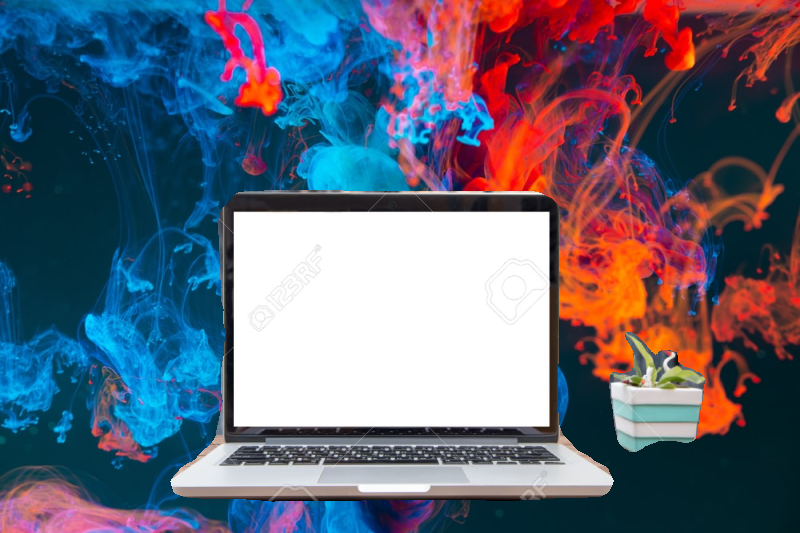

In [25]:
if (BACKGROUND == "Color") :
  cv2_imshow(final)
else :
  display(final)

Original Image: 


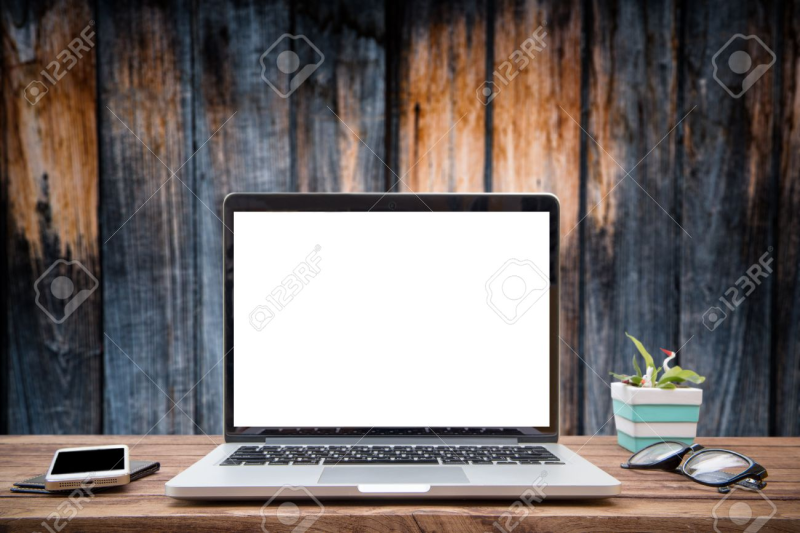

Background Image 


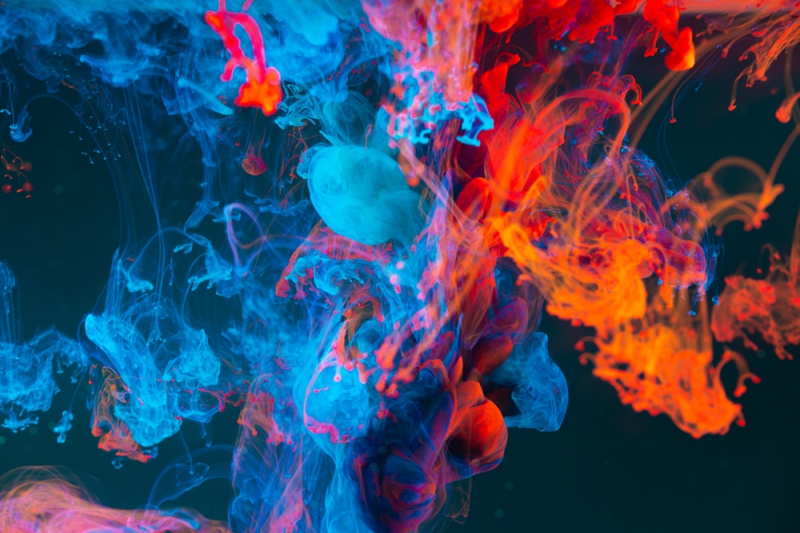

Mask


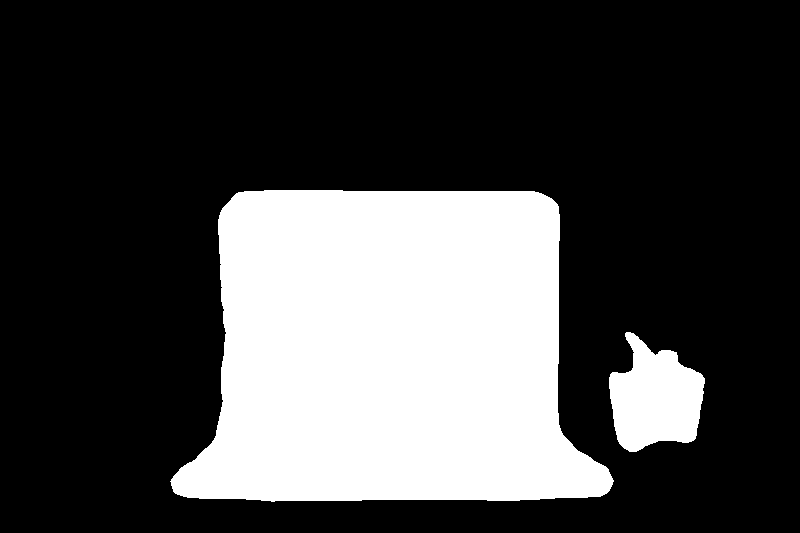

In [26]:
print("Original Image: ")
cv2_imshow(image)
print("Background Image ")
cv2_imshow(bg_image)
print("Mask")
cv2_imshow(mask)

# Approach 2 - Classical CV (Experimental)

## Input Area - Play with these parameters
In case you want a good ballpark 


1.   BG_COLOR = (255,255,255)
2.   BLUR = 3
3.   CANNY_LOW = 15
4.   CANNY_HIGH = 150
5.   MIN_AREA = 0.0005
6.   MAX_AREA = 0.95
7.   DILATE_ITER = 3
8.   ERODE_ITER = 3
9.   RESIZE = 500


  




In [113]:
#@title Input Parameters (Do Run After changing params)
USE_DEFAULT = True #@param {type:"boolean"}
BACKGROUND = "Background_Image" #@param ["Background_Image", "Color"]
BG_COLOR = (255,255,255) #@param {type:"raw"}
BLUR = 1 #@param [1,3,5,7,11,19,21] {type:"raw"}
CANNY_LOW = 5 #@param {type:"slider", min:1, max:40, step: 1}
CANNY_HIGH = 159 #@param{type:"slider", min:100, max:200, step:1}
MIN_AREA = 0.0005 #@param{type:"slider", min:0.0001, max:0.01, step:0.0001}
MAX_AREA = 0.9 #@param{type:"slider", min:0.1, max:0.99, step:0.01}
DILATE_ITER = 1 #@param [1,3,5,7,11,19,21] {type:"raw"}
ERODE_ITER = 1 #@param [1,3,5,7,11,19,21] {type:"raw"}
RESIZE = 500 #@param {type:"raw"}

if USE_DEFAULT:
  BG_COLOR = (255,255,255)
  BACKGROUND = "Background_Image"
  BLUR = 3
  CANNY_LOW = 15
  CANNY_HIGH = 150
  MIN_AREA = 0.0005
  MAX_AREA = 0.95
  DILATE_ITER = 3
  ERODE_ITER = 3
  RESIZE = 500

## Functions (Run-All)

In [114]:
# StreamLined Code
def read_image(image,bg,size):
  bg = bg
  image = image
  foreground = cv2.imread(image)
  background = cv2.imread(bg)
  foreground = imutils.resize(foreground, width=size)
  background = imutils.resize(background, width=size)

  return foreground,background

In [115]:
def preprocess(image):
  # convert the image to greyscale
  grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # detect lines and edges using canny
  edges = cv2.Canny(grey, CANNY_LOW, CANNY_HIGH)
  # dilate and erode the edges
  edges = cv2.dilate(edges,None) 
  edges = cv2.erode(edges,None)
  return edges

In [116]:
def masking(edges):
  edge = edges
  # get the contours and their areas
  contour_info = [(c, cv2.contourArea(c),_) for c in 
                  cv2.findContours(edge,
                                   cv2.RETR_LIST,
                                   cv2.CHAIN_APPROX_NONE)[0]]
  # Set up mask with a matrix of 0's
  mask = np.zeros(edge.shape, dtype = np.uint8)

  # Get the area of the image as a comparison
  image_area = edge.shape[0] * edge.shape[1]  

  # calculate max and min areas in terms of pixels
  max_area = MAX_AREA * image_area
  min_area = MIN_AREA * image_area

  # Go through and find relevant contours and apply to mask
  for contour in contour_info:
  #  Instead of worrying about all the smaller contours,
  # if the area is smaller than the min, the loop will break
    if contour[1] > min_area and contour[1] < max_area:
      # Add contour to mask
      mask = cv2.fillConvexPoly(mask, contour[0], (255))
  # use dilate, erode, and blur to smooth out the mask
    mask = cv2.dilate(mask, None, iterations=DILATE_ITER)
    mask = cv2.erode(mask, None, iterations=ERODE_ITER)
    mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)
  return mask

In [117]:
def background_replace(image,mask,background_image):
  background_image = background_image
  image = image
  mask = mask
  masked = cv2.bitwise_and(image,image,mask = mask)
  replaced = np.copy(masked)
  if (BACKGROUND == "Color"):
    replaced[mask==0] = BG_COLOR
  elif (BACKGROUND == "Background_Image"):
    masked = Image.fromarray(cv2.cvtColor(masked,
                                          cv2.COLOR_BGR2RGB))
    #masked = Image.fromarray(masked)
    masked = masked.convert("RGBA")
    pixdata = masked.load()
    width, height = masked.size
    for y in range(height):
      for x in range(width):
        if pixdata[x, y] == (0, 0, 0, 255):
            pixdata[x, y] = (255, 255, 255, 0)

    background_image = cv2.resize(background_image,
                                  (image.shape[1],
                                   image.shape[0]))
    background_image = Image.fromarray(cv2.cvtColor(background_image,
                                                    cv2.COLOR_BGR2RGB))
    background_image.paste(masked, (0, 0), masked)
    replaced = background_image
  return replaced

In [118]:
image,bg_image = read_image(foreground,background,RESIZE)
edges = preprocess(image)
mask = masking(edges)
final = background_replace(image,mask,bg_image)

## Output Area 

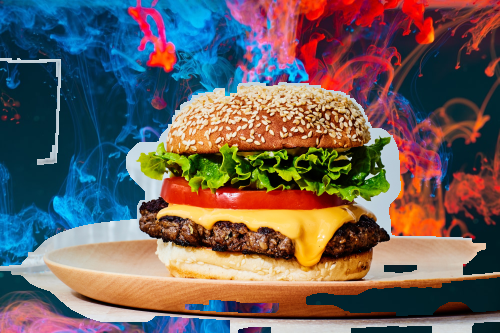

In [119]:
final

Original Image: 


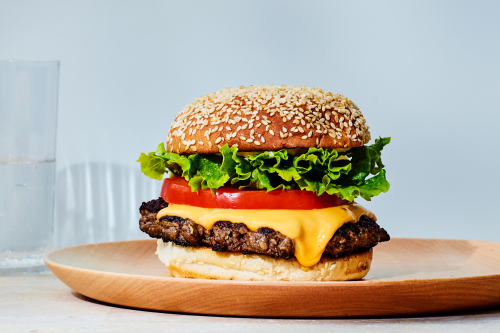

Background Image: 


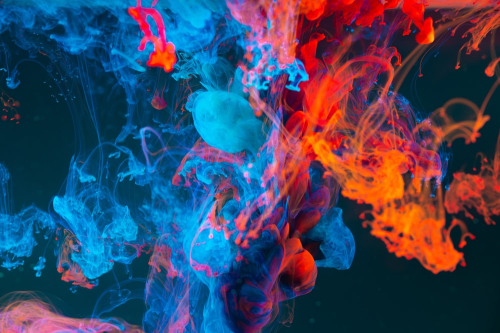

Extracted Edges: 


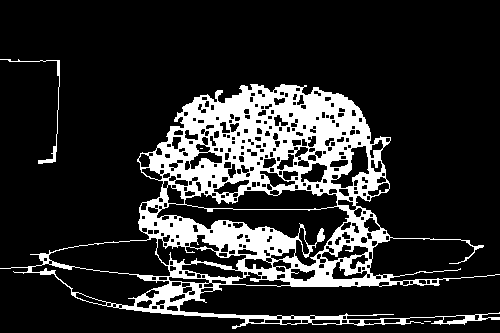

Contour Mask: 


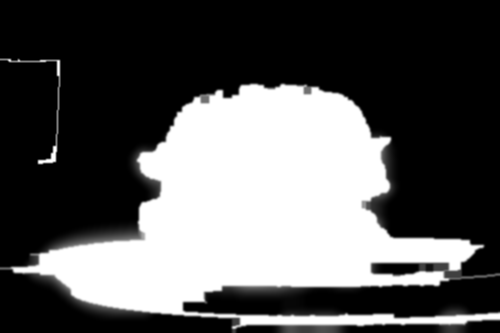

Final Output: 


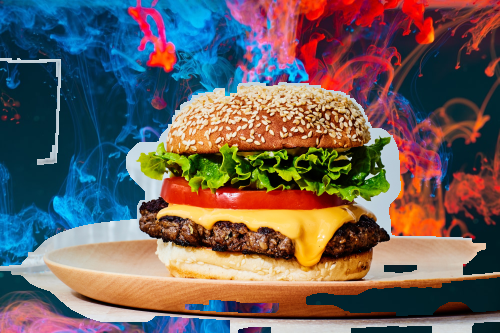

In [120]:
print("Original Image: ")
cv2_imshow(image)
print("Background Image: ")
cv2_imshow(bg_image)
print("Extracted Edges: ")
cv2_imshow(edges)
print("Contour Mask: ")
cv2_imshow(mask)
print("Final Output: ")
final